# Forward-backward splitting for time-varying graphical lasso
This notebook shows how to minimise the time-varying graphical lasso with element-wise penalty norms across time-points.

First of all, as always, let's create a bunch of data.
For this task, we generate eah variable to change according to a certain behaviour which can be described as evolution via tigonometric functions, such as `sin` and `cos`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from regain import datasets, utils

from sklearn.datasets import load_iris
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
# np.random.seed(7)

# fs = 10e3
# N = 100
# amp = 2*np.sqrt(2)
# freq = 1.0
# noise_power = 0.001 * fs / 2
# time = np.arange(N) / fs
# z = amp*np.sin(2*np.pi*freq*time)
# z += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
# plt.plot(z);

In [3]:
# T = 4

# x = np.tile(np.linspace(0, T-1, T), (n_interactions, 1))
# zz = amp * signal.square(2 * np.pi * freq * x + phase, duty=.5)
# plt.plot(x.T, zz.T);

Generate the data starting from the inverse covariance matrices.

In [ ]:
from regain.datasets import *

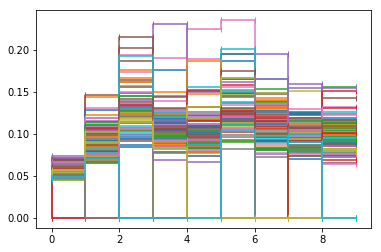

In [619]:
def make_sin(n_dim_obs, n_dim_lat, T, shape='smooth', closeness=1,
             normalize=False):
    upper_idx = np.triu_indices(n_dim_obs, 1)
    n_interactions = len(upper_idx[0])
    x = np.tile(np.linspace(0, (T-1.) / closeness, T), (n_interactions, 1))
    phase = np.random.rand(n_interactions, 1)
    freq = np.random.rand(n_interactions, 1) - .250
    A = (np.random.rand(n_interactions, 1) + 2) / 2.

    if shape == 'smooth':
        y = A * np.sin(2. * np.pi * freq * x + phase)
    else:
        y = A * signal.square(2 * np.pi * freq * x + phase, duty=.5)

    # threshold
    y = np.maximum(y, 0)

    Y = np.array([squareform(y[:, j]) + np.diag(np.sum(squareform(y[:, j]), axis=1))
                  for j in range(y.shape[1])])

    if normalize:
        map(normalize_matrix, Y)  # in place
    assert positive_definite(Y)

    return Y, Y, np.zeros_like(Y)

data = {}
np.random.seed(7)
data['square'] = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
                             time_on_axis='last',
                             mode=make_sin, shape='square', closeness=2.4, normalize=1)


plt.step(np.array([squareform(y, checks=None) for y in data['square'].thetas]), '-|');

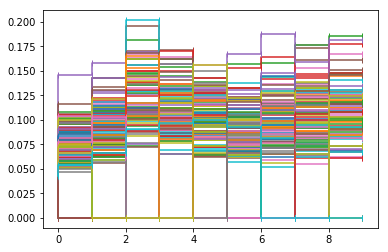

In [604]:
np.random.seed(7)

# square
n_samples = 100
n_dim_obs = 20
T = 10

data = {}
data['square'] = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
                             time_on_axis='last',
                             mode='sin', shape='square', closeness=2.4, normalize=1)

# smooth
n_samples = 100
n_dim_obs = 20
T = 10

data['smooth'] = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
                             time_on_axis='last',
                             mode='sin', shape='smooth', closeness=2.4, normalize=1)

plt.step(np.array([squareform(y, checks=None) for y in data['square'].thetas]), '-|');
# plt.savefig("/home/fede/Dropbox/Latent variables networks/forward backward time varying graphical lasso/smooth_signal.pdf")

### Let's run 

In [5]:
# X = data.data
# X_tr, X_ts = train_test_split(X)

In [577]:
import pandas as pd
from functools import partial
from regain import update_rules; reload(update_rules);
from regain.forward_backward import time_graph_lasso_; reload(time_graph_lasso_)

from sklearn.covariance import GraphLasso, GraphLassoCV
import sys; sys.path.append("/home/fede/src/TVGL")
import inferGraphL1; reload(inferGraphL1)
import inferGraphL2; reload(inferGraphL2)
import TVGL; reload(TVGL)

# use:
# beta = 2.1, norm = 1
# beta = 5.05, norm = 2
# prepare dataframe for results

methods = ['TGL-FB ($\ell_{21}$)', 'TGL-FB ($\ell_1$)', 'GL', 'TVGL ($\ell_{21}$)', 'TVGL ($\ell_1$)']

scores = sorted(['iter', 'accuracy',  'average_precision',  'balanced_accuracy','f1','false_omission_rate','fdr',
                 'fn',  'fp',  'precision',  'prevalence',  'recall',  'specificity',  'tn',  'tp'])
evolution = sorted(['square', 'smooth'])

rows = methods
cols = pd.MultiIndex.from_product([evolution, scores], names=('evolution', 'score'))
# rows = pd.MultiIndex.from_product([methods, n_times], names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [625]:
def run_performance(beta=1, alpha=1, evolution='square'):
    X = data[evolution].data
    
    error_function = partial(utils.structure_error, data[evolution].thetas,
                             no_diagonal=0, thresholding=1, eps=1e-4)

    tglfb = time_graph_lasso_.TimeGraphLassoForwardBackward(
        verbose=0, gamma=1, alpha=alpha, beta=beta,
        delta=1e-8, choose='lamda', lamda_criterion='c',
        lamda=1, tol=1e-5, eps=0.9,
        time_norm=2, max_iter=300, time_on_axis='last').fit(X)
#     print(tglfb.alpha_max(X))
#     return
    res = error_function(tglfb.precision_)
    res['iter'] = tglfb.n_iter_
    dff.loc['TGL-FB ($\ell_{21}$)', idx[evolution, :]] = [res[x] for x in scores]
    
    tglfb = tglfb.set_params(time_norm=1).fit(X)
    res = error_function(tglfb.precision_)
    res['iter'] = tglfb.n_iter_
    dff.loc['TGL-FB ($\ell_1$)', idx[evolution, :]] = [res[x] for x in scores]

    gl = GraphLasso(alpha=0.05)
#     gl = GraphLassoCV(alphas=list(np.logspace(-1, 0, 100)))
    precision_gl = np.array([gl.fit(x).precision_.copy() for x in X.transpose(2,0,1)])
    res = error_function(precision_gl)
    res['iter'] = gl.n_iter_
    dff.loc['GL', idx[evolution, :]] = [res[x] for x in scores]
    
    thetaSet, empCovSet, status, gvx = TVGL.TVGL(
        np.vstack(X.transpose(2,0,1)), X.shape[0],
        lamb=gl.alpha, beta=tglfb.beta, indexOfPenalty=2, verbose=False)

    res = error_function(np.array(thetaSet))
    res['iter'] = gvx.n_iter_
    dff.loc['TVGL ($\ell_{21}$)', idx[evolution, :]] = [res[x] for x in scores]
    
    thetaSet, empCovSet, status, gvx = TVGL.TVGL(
        np.vstack(X.transpose(2,0,1)), X.shape[0],
        lamb=gl.alpha, beta=tglfb.beta, indexOfPenalty=1, verbose=False)
    res = error_function(np.array(thetaSet))
    res['iter'] = gvx.n_iter_
    dff.loc['TVGL ($\ell_1$)', idx[evolution, :]] = [res[x] for x in scores]

In [626]:
run_performance(beta=1.09, alpha=0.55, evolution='square')
# run_performance(beta=5, alpha=0.53, evolution='smooth')

Use l-2 penalty function
10
lambda = 0.05, beta = 1.09
Use l-1 penalty function
10
lambda = 0.05, beta = 1.09


In [627]:
ss = ['accuracy', 'average_precision', 'balanced_accuracy', 'f1', 'iter']
# dff['smooth'].sort_values("f1", ascending=False)#[ss]
dff['square'].sort_values("f1", ascending=False)

score,accuracy,average_precision,balanced_accuracy,f1,false_omission_rate,fdr,fn,fp,iter,precision,prevalence,recall,specificity,tn,tp
TGL-FB ($\ell_1$),0.595,0.765479,0.500788,0.745443,0.5,0.404618,8,1612,4,0.595382,0.595,0.996639,0.00493827,8,2372
TGL-FB ($\ell_{21}$),0.594,0.760731,0.49916,0.745295,1,0.405405,4,1620,6,0.594595,0.595,0.998319,0,0,2376
GL,0.595,0.766288,0.563866,0.681353,0.5,0.359467,648,972,2,0.640533,0.595,0.727731,0.4,648,1732
TVGL ($\ell_1$),0.6235,0.729964,0.627238,0.657572,0.471241,0.283449,934,572,40,0.716551,0.595,0.607563,0.646914,1048,1446
TVGL ($\ell_{21}$),0.578,0.68922,0.620936,0.526906,0.512091,0.208754,1440,248,21,0.791246,0.595,0.394958,0.846914,1372,940


In [566]:
# dff.to_pickle("results_25_04_18.pkl")

obj: 21557.2890, rnorm: 6.4422319, snorm: 2769.1342,eps_pri: 0.0005, eps_dual: 0.0000
obj: 20139.2732, rnorm: 4.3849510, snorm: 1418.0158,eps_pri: 0.0005, eps_dual: 0.0000
obj: 19485.8988, rnorm: 1.2722573, snorm: 653.3744,eps_pri: 0.0005, eps_dual: 0.0000
obj: 19485.8988, rnorm: 0.0000000, snorm: 0.0000,eps_pri: 0.0005, eps_dual: 0.0000
obj: 18675.4757, rnorm: 1.6603892, snorm: 267.1486,eps_pri: 0.0005, eps_dual: 0.0000
obj: 18679.5814, rnorm: 1.2851161, snorm: 4.1057,eps_pri: 0.0005, eps_dual: 0.0000
obj: 18439.1244, rnorm: 0.8571792, snorm: 240.4570,eps_pri: 0.0005, eps_dual: 0.0000
obj: 18417.1152, rnorm: 0.2935183, snorm: 22.0093,eps_pri: 0.0005, eps_dual: 0.0000
obj: 18404.4473, rnorm: 0.1469089, snorm: 12.6678,eps_pri: 0.0005, eps_dual: 0.0000
obj: 18404.4473, rnorm: 0.0000000, snorm: 0.0000,eps_pri: 0.0005, eps_dual: 0.0000


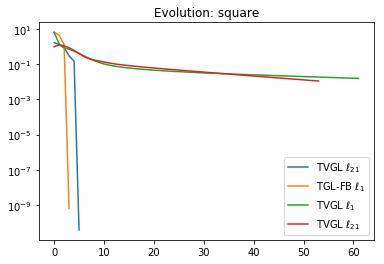

In [623]:
evolution = 'square'; alpha = 0.55; beta = 1.09
# evolution = 'smooth'; alpha = 0.53; beta = 5
from regain import prox; reload(prox)
from regain import norm; reload(norm)
reload(time_graph_lasso_)
X = data[evolution].data


tglfb_square = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=2, gamma=1, alpha=alpha, beta=beta,
    delta=1e-8, choose='lamda', lamda_criterion='c',
    lamda=1, tol=1e-5, eps=0.9, return_history=True,
    time_norm=1, max_iter=300, time_on_axis='last').fit(X)

tglfb_smooth = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=2, gamma=1, alpha=alpha, beta=beta,
    delta=1e-8, choose='lamda', lamda_criterion='c',
    lamda=1, tol=1e-5, eps=0.9, return_history=True,
    time_norm=2, max_iter=300, time_on_axis='last').fit(X)

# thetaSet, empCovSet, status, gvx_square = TVGL.TVGL(
#     np.vstack(X.transpose(2,0,1)), X.shape[0],
#     lamb=alpha, beta=beta, indexOfPenalty=2, verbose=False, epsAbs=1e-5)
# thetaSet, empCovSet, status, gvx_smooth = TVGL.TVGL(
#     np.vstack(X.transpose(2,0,1)), X.shape[0],
#     lamb=alpha, beta=beta, indexOfPenalty=1, verbose=False, epsAbs=1e-5)

plt.title("Evolution: %s" % evolution)
plt.semilogy([x.rnorm for x in tglfb_smooth.history_], label='TVGL $\ell_{21}$')
plt.semilogy([x.rnorm for x in tglfb_square.history_], label='TGL-FB $\ell_1$')
plt.semilogy([x for x in gvx_square.history_], label='TVGL $\ell_1$')
plt.semilogy([x for x in gvx_smooth.history_], label='TVGL $\ell_{21}$')
plt.legend()

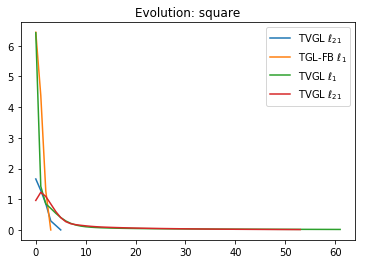

In [624]:
plt.title("Evolution: %s" % evolution)
plt.plot([x.rnorm for x in tglfb_smooth.history_], label='TVGL $\ell_{21}$')
plt.plot([x.rnorm for x in tglfb_square.history_], label='TGL-FB $\ell_1$')
plt.plot([x for x in gvx_square.history_], label='TVGL $\ell_1$')
plt.plot([x for x in gvx_smooth.history_], label='TVGL $\ell_{21}$')
plt.legend()
# plt.xlim([0,5])

In [214]:
error_function = partial(utils.structure_error, data[evolution].thetas,
                             no_diagonal=0, thresholding=1, eps=1e-4)

res = error_function(tglfb.precision_)
res

{'accuracy': 0.59,
 'average_precision': 0.7827281349725472,
 'balanced_accuracy': 0.5006090133982948,
 'dor': 0,
 'f1': 0.7419760855884204,
 'fall_out': 0.9987819732034104,
 'false_omission_rate': 0.0,
 'fdr': 0.4102051025512756,
 'fn': 0,
 'fp': 1640,
 'miss_rate': 0.0,
 'nlr': 0.0,
 'npv': 1.0,
 'plr': 1.001219512195122,
 'precision': 0.5897948974487244,
 'prevalence': 0.5895,
 'recall': 1.0,
 'specificity': 0.001218026796589525,
 'tn': 2,
 'tp': 2358}

In [156]:
tglfb.n_iter_

2

In [157]:
np.abs(tglfb.precision_).min()

0.0

### BayesOptimisation
Since we have lots of hyper-parameters, we rely on a Bayesian optimisation procedure in order to select the best hyper-parameters, treating the scoring function of our algorithm as a black-box for the gaussian process underlying the Bayesian optimisation.

Such procedure is performed via the `scikit-optimize` package.

In [393]:
from regain import utils; reload(utils)
from regain import prox; reload(prox);
from regain.forward_backward import time_graph_lasso_; reload(time_graph_lasso_)

from skopt import searchcv; reload(searchcv)

X = data['square'].data

domain = {'alpha': Real(1e-1, 3, prior='uniform'),
          'beta': Real(1e-1, 1e1, prior='uniform'),
#           'time_norm': Categorical([1, 2])
#           'eps': Categorical([0.5, 0.7, 0.8, 0.9])
         }

mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, tol=1e-5, max_iter=200, gamma=1, beta=2.1, time_norm=1,
    time_on_axis='last', alpha=.77,
    delta=1e-8, choose='lamda', lamda_criterion='c', eps=0.9)
    
cv = ShuffleSplit(5, test_size=0.2)
    
bscv = searchcv.BayesSearchCV(
    mdl, domain, n_iter=100, cv=cv, verbose=0, n_jobs=1, iid=True, n_points=3,
    error_score=-3e5)

def on_step(optim_result):
    score = bscv.best_score_
#     print("best score: %s" % score)

# bscv.fit(X, callback=on_step)

In [395]:
bscv_smooth.best_params_

{'alpha': 0.5304528578823566, 'beta': 4.9818959588448735}

In [394]:
# searchCV on smooth data set
domain = {'alpha': Real(0.1, 1, prior='uniform'),
          'beta': Real(0.5, 5, prior='uniform'),
#           'time_norm': Categorical([1, 2])
#           'eps': Categorical([0.5, 0.7, 0.8, 0.9])
         }
bscv_smooth = searchcv.BayesSearchCV(
    mdl, domain, n_iter=300, cv=cv, verbose=0, n_jobs=1, iid=True, n_points=3,
    error_score=-3e5)

def on_step(optim_result):
    score = bscv_smooth.best_score_
#     print("best score: %s" % score)

bscv_smooth.fit(data['smooth'].data, callback=on_step)

BayesSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None),
       error_score=-300000.0,
       estimator=TimeGraphLassoForwardBackward(alpha=0.77, assume_centered=False, beta=2.1,
               choose='lamda', compute_objective=True, delta=1e-08,
               eps=0.9, gamma=1, lamda=1, lamda_criterion='c',
               max_iter=200, time_norm=1, time_on_axis='last', tol=1e-05,
               verbose=0),
       fit_params=None, iid=True, n_iter=300, n_jobs=1, n_points=3,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'alpha': Real(low=0.1, high=1, prior='uniform', transform='identity'), 'beta': Real(low=0.5, high=5, prior='uniform', transform='identity')},
       verbose=0)

### GridSearchCV
As for the hyper-parameters tuning, one may choose to fix a grid of parameters and select the best ones.
For this we can use `GridSearchCV`, from the `scikit-learn` library.

In [ ]:
param_grid=dict(alpha=np.logspace(-2,0,3), beta=np.logspace(-2,0,3),
                time_norm=[1, 2])

mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, time_on_axis='last')
    
cv = ShuffleSplit(2, test_size=0.2)
ltgl = GridSearchCV(mdl, param_grid, cv=cv, verbose=1)
ltgl.fit(data_grid)